In [1]:
import os
import lasagne.easy
os.environ["THEANO_FLAGS"] = "device=gpu"
from lasagne.datasets.mnist import  MNIST
from sklearn.utils  import shuffle
from sklearn.cross_validation import train_test_split

data = MNIST()
data.load()
X, y = data.X, data.y

X, y = shuffle(X, y)

X = X.reshape((X.shape[0], 1, 28, 28))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
from lasagne.layers import cuda_convnet


Using gpu device 0: Tesla K20m


## model definition

In [5]:

import matplotlib as mpl
import numpy as np

from lasagne.generative import va
from lasagne.easy import (BatchOptimizer, LightweightModel,
                          get_2d_square_image_view)
from lasagne.layers.batch_norm import batch_norm
from lasagne.misc.plot_weights import grid_plot
from lasagne import layers, nonlinearities, updates, init
from sklearn.datasets import load_digits
from lasagne.datasets.mnist import MNIST
from lasagne.datasets.faces import Faces
import theano
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

from theano.sandbox import rng_mrg
import time


state = 1
z_dim = 100
hidden = 1500
learning_rate = 0.000112
max_epochs = 30
batch_size = 512
batch_normalization = False 
nb_layers = 1


class Unpool2DLayer(layers.Layer):
    """
    This layer performs unpooling over the last two dimensions
    of a 4D tensor.
    """
    def __init__(self, incoming, ds, **kwargs):
        
        super(Unpool2DLayer, self).__init__(incoming, **kwargs)

        if (isinstance(ds, int)):
            raise ValueError('ds must have len == 2')
        else:
            ds = tuple(ds)
            if len(ds) != 2:
                raise ValueError('ds must have len == 2')
            if ds[0] != ds[1]:
                raise ValueError('ds should be symmetric (I am lazy)')
            self.ds = ds

    def get_output_shape_for(self, input_shape):
        output_shape = list(input_shape)

        output_shape[2] = input_shape[2] * self.ds[0]
        output_shape[3] = input_shape[3] * self.ds[1]

        return tuple(output_shape)

    def get_output_for(self, input, **kwargs):
        ds = self.ds
        input_shape = input.shape
        output_shape = self.get_output_shape_for(input_shape)
        return input.repeat(2, axis = 2).repeat(2, axis = 3)

def build_model_encoder(input_width, input_height,
                z_dim,
                dimshuffle=True):
    l_in = lasagne.layers.InputLayer(
        shape=(None, 1, input_width, input_height),
    )
    if not dimshuffle:
        l_in = cuda_convnet.bc01_to_c01b(l_in)
    l_conv1 = cuda_convnet.Conv2DCCLayer(
        l_in,
        num_filters=32,
        filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        dimshuffle=dimshuffle,
    )
    l_pool1 = cuda_convnet.MaxPool2DCCLayer(
        l_conv1,
        pool_size=(2, 2),
        dimshuffle=dimshuffle,
    )

    l_conv2 = cuda_convnet.Conv2DCCLayer(
        l_pool1,
        num_filters=32,
        filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        dimshuffle=dimshuffle,
    )
    l_pool2 = cuda_convnet.MaxPool2DCCLayer(
        l_conv2,
        pool_size=(2, 2),
        dimshuffle=dimshuffle,
    )
    if not dimshuffle:
        l_pool2 = cuda_convnet.c01b_to_bc01(l_pool2)
    l_hidden1 = lasagne.layers.DenseLayer(
        l_pool2,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
    )

    #l_hidden1_dropout = lasagne.layers.DropoutLayer(l_hidden1, p=0.5)
    l_hidden1_dropout = l_hidden1
    # l_hidden2 = lasagne.layers.DenseLayer(
    #     l_hidden1_dropout,
    #     num_units=256,
    #     nonlinearity=lasagne.nonlinearities.rectify,
    #     )
    # l_hidden2_dropout = lasagne.layers.DropoutLayer(l_hidden2, p=0.5)
    h = l_hidden1_dropout
    z_mean_out = layers.DenseLayer(h, num_units=z_dim,
                                   nonlinearity=nonlinearities.linear)
    z_sigma_out = layers.DenseLayer(h, num_units=z_dim,
                                    nonlinearity=nonlinearities.linear)

    nnet_x_to_z = LightweightModel([l_in],
                                   [z_mean_out, z_sigma_out])

    return nnet_x_to_z



def build_model_decoder(w, h, z_dim, dimshuffle=True):
    z_in = layers.InputLayer(shape=(None, z_dim))
    Z_tensor = T.matrix()
    if not dimshuffle:
        z_in = cuda_convnet.bc01_to_c01b(z_in)

    h = layers.DenseLayer(z_in, 
                          num_units=40*40)
    h = layers.ReshapeLayer(h, ([0], 1, 40, 40))
    l_conv1 = cuda_convnet.Conv2DCCLayer(
        h,
        num_filters=16,
        filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        dimshuffle=dimshuffle,
    )
    l_conv2 = cuda_convnet.Conv2DCCLayer(
        l_conv1,
        num_filters=16,
        filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        dimshuffle=dimshuffle,
    )
    h=l_conv2
    x_out = layers.DenseLayer(h, num_units=28*28, nonlinearity=nonlinearities.linear)
    x_out = layers.ReshapeLayer(x_out, ([0], 1, 28, 28))
    nnet_z_to_x = LightweightModel([z_in], [x_out])
    return nnet_z_to_x


# X to Z (decoder)
nnet_x_to_z = build_model_encoder(28, 28, z_dim)
# Z to X (encoder)
nnet_z_to_x = build_model_decoder(28, 28, z_dim)
# instantiate the model
class MyBatchOptimizer(BatchOptimizer):

    def iter_update(self, epoch, nb_batches, iter_update_batch):
        status = super(MyBatchOptimizer, self).iter_update(epoch, nb_batches, iter_update_batch)
        #status["reconstruction_error"] = self.model.reconstruction_error_function(X)
        #status["lower_bound_train"] = self.model.get_likelihood_lower_bound(X_train)
        status["lower_bound_validation"] = self.model.get_likelihood_lower_bound(X_valid)
        return status

batch_optimizer = MyBatchOptimizer(max_nb_epochs=max_epochs,
                                   optimization_procedure=(updates.rmsprop, {"learning_rate": learning_rate}),
                                   verbose=2,
                                   whole_dataset_in_device=True,
                                   patience_nb_epochs=25,
                                   patience_stat="lower_bound_validation",
                                   patience_progression_rate_threshold=0.99,
                                   patience_check_each=10,
                                   batch_size=batch_size)

model = va.VariationalAutoencoder(nnet_x_to_z, nnet_z_to_x, 
                                  batch_optimizer, 
                                  rng=rng_mrg.MRG_RandomStreams(seed=state),
                                  X_type=T.tensor4,
                                  nb_z_samples=1)

In [6]:
model.fit(X_train)

  epoch    loss_std    loss_train    lower_bound_validation
-------  ----------  ------------  ------------------------
      0     67.5622       231.862                    204.06
  epoch    loss_std    loss_train    lower_bound_validation
-------  ----------  ------------  ------------------------
      1     3.39119       195.659                   194.173
  epoch    loss_std    loss_train    lower_bound_validation
-------  ----------  ------------  ------------------------
      2     4.90956       183.332                   179.505
  epoch    loss_std    loss_train    lower_bound_validation
-------  ----------  ------------  ------------------------
      3     3.67989       170.258                    169.44
  epoch    loss_std    loss_train    lower_bound_validation
-------  ----------  ------------  ------------------------
      4     2.88956        161.68                   161.527
  epoch    loss_std    loss_train    lower_bound_validation
-------  ----------  ------------  -----

/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/easy.py:804: UserWarning: layer.get_output(...) is deprecated and will be removed for the first release of Lasagne. Please use lasagne.layers.get_output(layer, ...) instead.
  for output_layer in self.output_layers]
/home/gridcl/mehdicherti/work/code/Lasagne/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


## Visualizations

In [11]:

from IPython.html.widgets.interaction import interactive
from IPython.html import widgets
from IPython.display import display
%matplotlib inline

samples = model.sample(100, only_means=True)


params = {}
for i in range(z_dim):
    a = model._prior_z_mean.get_value()[i]
    b = np.exp(model._prior_z_log_sigma.get_value()[i])
    params[str(i)] = (int(a-b-1)*1.,int(a+b+1)*1.)

#z = h_mean[np.random.randint(0, h_mean.shape[0], size=(1,)), :]
z = np.random.multivariate_normal(model._prior_z_mean.get_value(), 
                                  np.diag(np.exp(model._prior_z_log_sigma.get_value())), 
                                  size=(1,)).astype(np.float32)
print(model._prior_z_mean.get_value())
print(params)
print(z.shape)

(100, 100)
[ 0.11581545  0.00238682  0.0197144  -0.00190649  0.10551221  0.00477988
  0.05770661  0.13057837  0.16243683 -0.06028895  0.12188736  0.11142149
  0.09111894 -0.02992764 -0.08008874 -0.09360076  0.02598526 -0.16722734
  0.1827299  -0.01820174 -0.06355552 -0.05041436 -0.06286643  0.02744174
 -0.17453587  0.03043643  0.14840098 -0.00505337  0.04723967  0.09247006
 -0.1383201   0.11722916 -0.07232839  0.05415151  0.1581091   0.01107049
  0.11205839 -0.19110358 -0.02523515 -0.12513635  0.05371831  0.01144906
  0.07161642 -0.21412963  0.04752268  0.19899955  0.12669776  0.16224906
  0.01856357 -0.09372676  0.15168934  0.02939325  0.11475471 -0.01218663
 -0.12595151  0.02996385 -0.05714143 -0.12455031  0.09546629 -0.17599316
 -0.14803663 -0.07587293  0.06149539  0.06662175 -0.07559497 -0.14008203
 -0.140955   -0.00441151  0.01476398  0.13874163 -0.11202654  0.03398453
 -0.01554769 -0.01554493 -0.18661043  0.11456615  0.02136119 -0.0933844
 -0.11711957  0.04246172  0.09202874  0.1

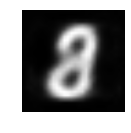

In [12]:
def sample(**params):    
    fig = plt.figure()

    z = [None] * z_dim
    for i in params.keys():
        z[int(i)] = params[i]
    z = np.array(z)[np.newaxis, :].astype(np.float32)
    s, = model.decode(z)
    #s = samples
    s = get_2d_square_image_view(s)
    grid_plot(s[:, 0], imshow_options={"cmap": "gray"}, fig=fig)
    plt.show()

def on_button_clicked(b):
    
    #p = {}
    #for i in params.keys():
    #    min_, max_ = params[i]
    #    p[i] = np.random.uniform(min_, max_)
    #    f.children[int(i)].value = p[i]
    #k = 0
    for i in range(10):
        
        a = model._prior_z_mean.get_value()[i]
        b = np.exp(model._prior_z_log_sigma.get_value()[i])
        f.children[i].value = np.random.normal(a, b)

    
    i = np.random.randint(0, 10)
    j = np.random.randint(0, 10)
    #k = np.random.randint(0, 10)

    a, b = params[str(i)]
    alpha = np.arange(a, b, 0.1)
    for a in alpha:
        f.children[i].value = a
        #f.children[j].value = -a
        #f.children[k].value = a
        
button = widgets.Button(description="Click Me!")
button.on_click(on_button_clicked)

f = interactive(sample, **params)
display(f)
display(button)

(100, 100)


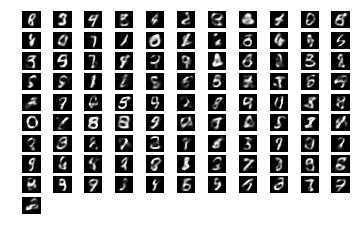

In [13]:
samples = model.sample(100, only_means=True)
grid_plot(get_2d_square_image_view(samples[:, 0]), imshow_options={"cmap": "gray"})
plt.show()